In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
#Download the Dataset
! curl -L "https://app.roboflow.com/ds/2blddBwCO9?key=eBxZH2Jy9L" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/labels/110_jpg.rf.d55dc9a4a740e0ac1e65624dfb5c14e6.txt  
 extracting: train/labels/111_jpg.rf.38095c96057cd5a77d140ce961693cb5.txt  
 extracting: train/labels/111_jpg.rf.9fad7462715502eb0bec7f8aa3669114.txt  
 extracting: train/labels/111_jpg.rf.f3df7bb69aee577f98ff0b0a091c0f39.txt  
 extracting: train/labels/113_jpg.rf.1779ea5be0cda8a5a083ee21ee345485.txt  
 extracting: train/labels/113_jpg.rf.17bfb4e1ab781701f6d7f820a7e132d0.txt  
 extracting: train/labels/113_jpg.rf.20c12fc9990f423d12480fb9bef86128.txt  
 extracting: train/labels/113_jpg.rf.4d89daf9ede89d76e15bfe098b79c103.txt  
 extracting: train/labels/113_jpg.rf.6725d2191a8ee61317b2e9d0b907c5e6.txt  
 extracting: train/labels/113_jpg.rf.7249b14a9e72198eef2a774c9095b147.txt  
 extracting: train/labels/113_jpg.rf.78711d9385d29d1739e26dd062c1f088.txt  
 extracting: train/labels/113_jpg.rf.9dbc9890511965d661cd29d17dd549ef.txt  
 extracting: train/labels/113_jpg.rf.

In [ ]:
#Visualize Images from the Dataset
import numpy as np
class_names = ['Peugeot 206', 'Peugeot Persia Pars', 'Pride Saipa111', 'Pride Saipa131', 'Renault Tondar 90', 'Saipa Quik']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))


# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):

    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

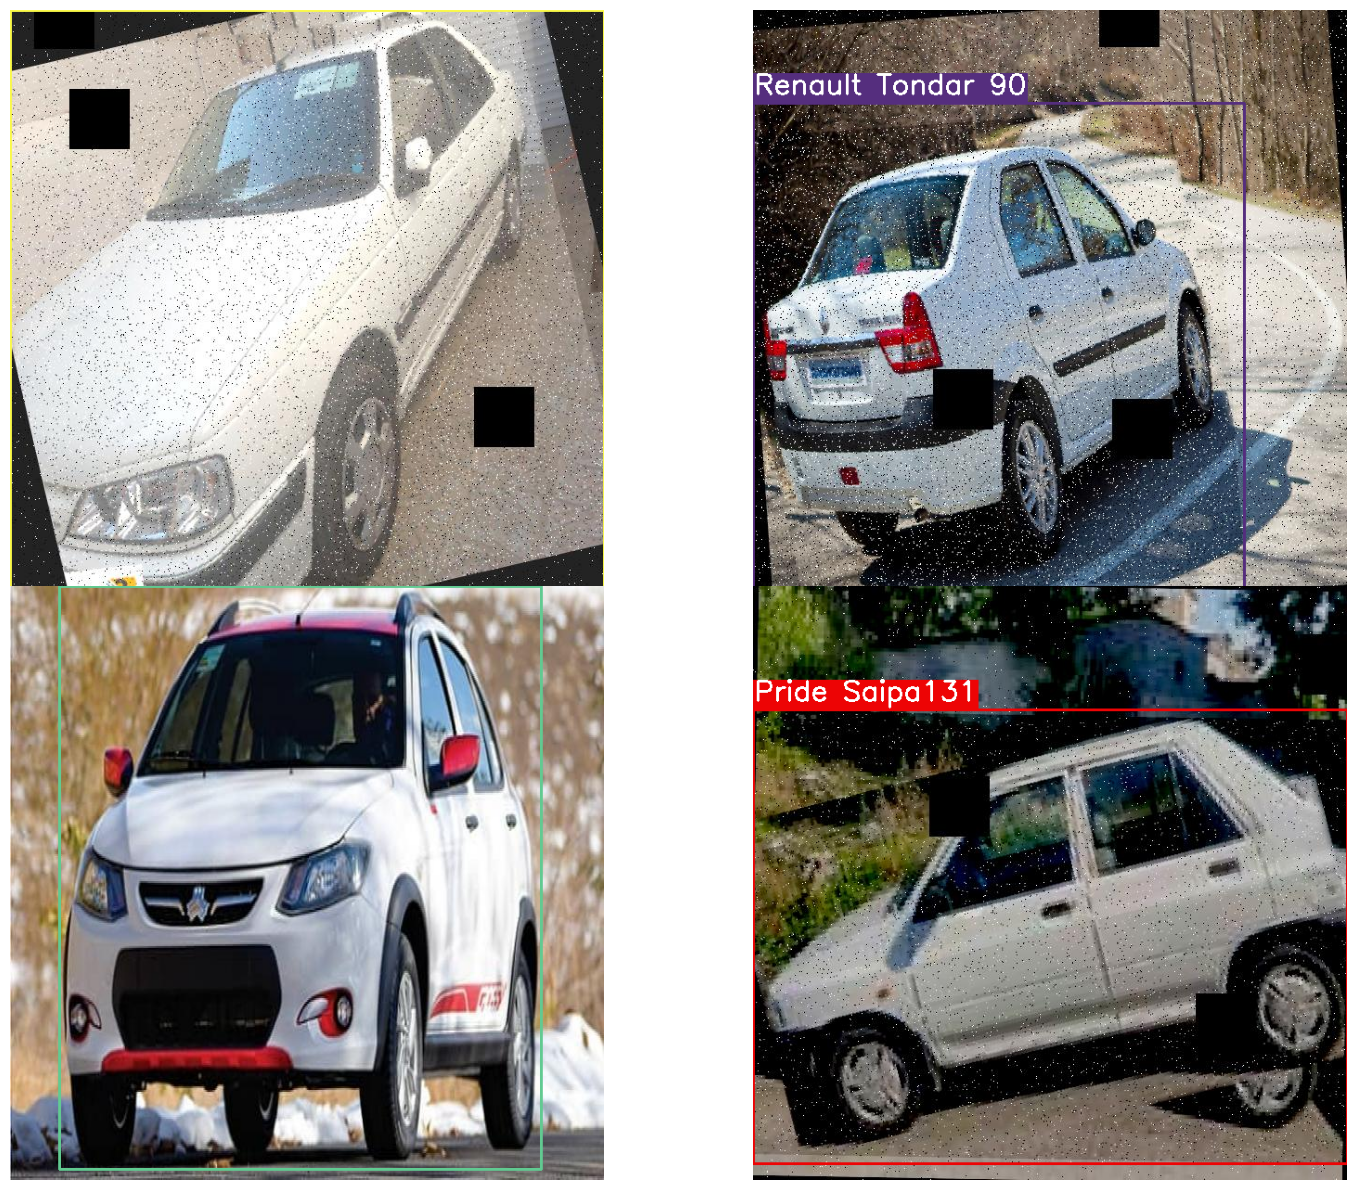

In [ ]:
# Visualize a few training images.
plot(
    image_paths='/content/train/images',
    label_paths='/content/train/labels',
    num_samples=4,
)

In [ ]:
#training for 25 epoch.
EPOCHS = 25

!yolo task=detect mode=train model=yolov8s.pt imgsz=640 data=/content/data.yaml epochs={EPOCHS} batch=16 name=yolov8s_model

100% 21.5M/21.5M [00:00<00:00, 366MB/s]
Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript

In [ ]:
#Evaluation on Validation Images
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=pothole_v8.yaml

Ultralytics YOLOv8.0.21 🚀 Python-3.9.15 torch-1.12.0+cu116 CUDA:0 (NVIDIA GeForce GTX 1060, 6078MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blo
val: WARNING ⚠️ /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011603.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011614.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /media/sovit/hdd1tbinternal/my_data/Data_Science/Big_Vision/my_blogs/Train-YOLOv8-on-Custom-Dataset-Complete-Tutorial/notebooks/datasets/pothole_dataset_v8/valid/images/G0011616.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /media/sovit/hdd1tbinternal/my_data/Data_Scie

In [ ]:
#Inference on Images
import glob as glob

def inference(data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('/content/drive/MyDrive/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !yolo task=detect \
    mode=predict \
    model=/content/drive/MyDrive/runs/detect/yolov8s_model/weights/best.pt \
    source={data_path} \
    imgsz=640 \
    name={INFER_DIR}
    return INFER_DIR


In [ ]:
#Visualize Results
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=1):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

In [ ]:
dResult = inference('/content/9.jpg')
visualize('/content/drive/MyDrive/detect/'+dResult)

Current number of inference detection directories: 4
inference_5
Ultralytics YOLOv8.0.165 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (AMD EPYC 7B12)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients

image 1/1 /content/9.jpg: 256x640 1 Peugeot 206, 1 Peugeot Persia Pars, 1 Saipa Quik, 188.7ms
Speed: 1.5ms preprocess, 188.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 640)
Results saved to runs/detect/inference_53


<Figure size 2000x1200 with 0 Axes>

In [ ]:
inference('/content/1.mp4')

Current number of inference detection directories: 4
inference_5
Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients

video 1/1 (1/207) /content/1.mp4: 384x640 (no detections), 99.3ms
video 1/1 (2/207) /content/1.mp4: 384x640 (no detections), 11.1ms
video 1/1 (3/207) /content/1.mp4: 384x640 (no detections), 11.1ms
video 1/1 (4/207) /content/1.mp4: 384x640 (no detections), 11.1ms
video 1/1 (5/207) /content/1.mp4: 384x640 1 Saipa Quik, 11.1ms
video 1/1 (6/207) /content/1.mp4: 384x640 (no detections), 11.4ms
video 1/1 (7/207) /content/1.mp4: 384x640 (no detections), 11.1ms
video 1/1 (8/207) /content/1.mp4: 384x640 (no detections), 11.1ms
video 1/1 (9/207) /content/1.mp4: 384x640 (no detections), 11.1ms
video 1/1 (10/207) /content/1.mp4: 384x640 (no detections), 11.2ms
video 1/1 (11/207) /content/1.mp4: 384x640 (no detections), 11.2ms
video 1/1 (12/207) /content/1.mp4: 384x640 (no detect

'inference_5'